In [49]:
import xgboost
import shap
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, make_scorer, cohen_kappa_score
from sklearn.utils.multiclass import unique_labels
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import pickle

In [33]:
# the dataset is from DesignSafe
data = 'RF_YN_Model3_orig.csv'
df = pd.read_csv(data)
df.head()

,Test ID,easting__N,northing__,GWD (m),Elevation,L (m),Slope (%),PGA (g),Meas class,CM pred
0,182.0,1.577615e+06,5.181562e+06,0.370809,0.909116,319.116999,5.465739,0.546270,0,TN
1,15635.0,1.577647e+06,5.182056e+06,1.300896,1.123009,211.770466,0.905948,0.532398,0,TN
2,8292.0,1.577654e+06,5.182040e+06,1.300896,0.847858,195.947250,0.849104,0.532398,0,TN
3,15629.0,1.577685e+06,5.181809e+06,1.788212,2.044325,115.795053,0.451034,0.542307,0,TN
4,183.0,1.577701e+06,5.181709e+06,1.637517,2.003797,137.265348,0.941866,0.545784,1,TP


# Data preprocessing

In [34]:
#trim outliers with IQR method
Q1 = df['Elevation'].quantile(0.25)
Q3 = df['Elevation'].quantile(0.75)
IQR = Q3-Q1
print(f'IQR: {IQR:.2f}')
trimming_matrix = (df['Elevation'] >= (Q1-1.5*IQR)) & (df['Elevation'] <= (Q3+1.5*IQR))
df = df[trimming_matrix]

IQR: 2.13


In [35]:
# these procedures are to make sure that the dataset compatible with the original script.
# insert the distance(km) column
df.insert(5,'L (km)',df['L (m)'].values/1000)

# rename Meas class as Target
df = df.rename(columns={'Meas class':'Target'})

# drop unnecessary columns
df = df.drop(['Test ID', 'easting__N', 'northing__', 'L (m)', 'CM pred'],axis=1)
X = df.copy(deep=True)

In [36]:
#define features matrix (X) and target (y)

y = df.drop(['GWD (m)', 'Elevation',  'L (km)', 'Slope (%)','PGA (g)'],axis=1)

# implementing train-test-split
X_train_target, X_test_target, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_all = X.drop(['Target'], axis=1)
X_train = X_train_target.drop(['Target'], axis = 1)
X_test = X_test_target.drop(['Target'], axis = 1)

In [37]:
eval_set = [(X_train, y_train), (X_test, y_test)]

# Optimize model

In [436]:
# Classifier fit with random search
kappa_scorer = make_scorer(cohen_kappa_score)
# Random-Search
param_dist={
    'max_depth': range(2,8),
    'n_estimators': range(2,100),
}

n_iter_search = 100
clf = RandomizedSearchCV(
    estimator=xgboost.sklearn.XGBClassifier(use_label_encoder=False, eta=0.4, grow_policy='lossguide'),
    param_distributions=param_dist, 
    n_iter=n_iter_search, 
    cv=10,
    verbose=0,
    n_jobs=-1,
    random_state=0,
    return_train_score=True,
    
)

start = time.time()
clf.fit(X_train, y_train, eval_metric=['error', 'logloss'], \
          early_stopping_rounds=10, eval_set=eval_set, verbose=False)
end = time.time()
print(f'random search took {(end-start):.2f} seconds')

/opt/homebrew/Caskroom/miniforge/base/envs/xai/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/opt/homebrew/Caskroom/miniforge/base/envs/xai/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/opt/homebrew/Caskroom/miniforge/base/envs/xai/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/opt/homebrew/Caskroom/miniforge/base/envs/xai/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.

random search took 1297.37 seconds


In [437]:
# Set model as the best estimator and save
model = clf.best_estimator_
print("Best parameters: ", clf.best_params_)
# save model
with open('xgb-classifier.pkl', 'wb') as f:
    pickle.dump(model, f)


Best parameters:  {'n_estimators': 61, 'max_depth': 7}


In [450]:
# Load pickle model
with open('xgb-classifier.pkl', 'rb') as f:
    model = pickle.load(f)

In [452]:
# Classifier fit
model = xgboost.XGBClassifier(use_label_encoder=False, max_depth=5, eta=0.4, n_estimators=100)
# model = xgboost.XGBClassifier(use_label_encoder=False, max_depth=7, eta=0.4, n_estimators=61)
model.fit(X_train, y_train, eval_metric=['error', 'logloss'], \
          early_stopping_rounds=10, eval_set=eval_set, verbose=False)

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eta=0.4, gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.400000006,
              max_delta_step=0, max_depth=5, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=10,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [453]:
print('Training score: %.2f%%' %(model.score(X_train, y_train) * 100))
print('Testing score: %.2f%%' %(model.score(X_test, y_test) * 100))
print('Overall score: %.2f%%' %(model.score(X_all, y) * 100))

Training score: 97.13%
Testing score: 85.12%
Overall score: 94.72%


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


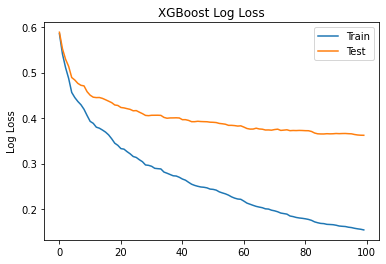

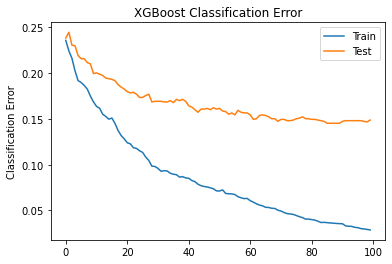

In [454]:
# retrieve performance metrics
results = model.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.show()
# plot classification error
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
plt.ylabel('Classification Error')
plt.title('XGBoost Classification Error')
plt.show()